In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import cv2
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
%matplotlib inline

## 读取数据

In [2]:
with open('./data/driving_log.csv') as csvfile:
    read_file = csv.reader(csvfile)
    rows = []
    for row in read_file:
        rows.append(row)

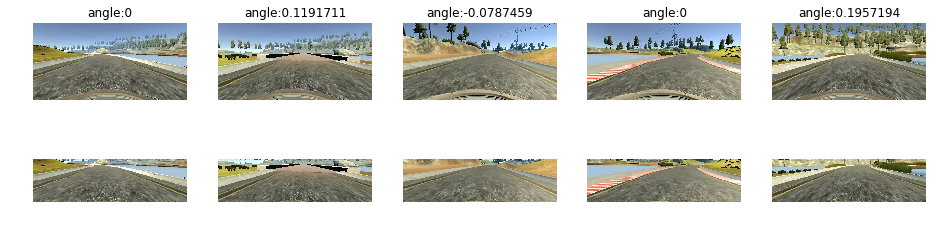

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(16,4))
axes = axes.ravel()
for i in range(5):
    idx = random.randint(0,len(rows))
    img_name = rows[idx][0].split('/')[-1]
    img_path = './data/IMG/' + img_name
    axes[i].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
    axes[i].set_title('angle:' + rows[idx][3])
    axes[i+5].imshow(cv2.cvtColor(cv2.imread(img_path)[50:160-20,:], cv2.COLOR_BGR2RGB))
    axes[i+5].axis('off')

In [4]:
train_samples, val_samples = train_test_split(rows, test_size=0.25)

def generator(samples, batch_size=64):
    n_samples = len(samples)
    path = './data/IMG/'
    #path = './data_uda/IMG/'
    while 1:
        shuffle(samples)
        for offset in range(0, n_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            batch_images = []
            batch_angles = []
            for sample in batch_samples:
                #设置左右摄像头校准角度
                correction = 0.2
                angle_center = float(sample[3])
                angle_left = angle_center + correction
                angle_right = angle_center - correction
                #包含左右摄像头数据，并左右翻转图片，以增加数据量
                img_center = cv2.imread(path + sample[0].split('/')[-1])
                flipped_center = cv2.flip(img_center, 1)
                flipped_angle_center = -angle_center
                img_left = cv2.imread(path + sample[1].split('/')[-1])
                flipped_left = cv2.flip(img_left, 1)
                flipped_angle_left = -angle_left
                img_right = cv2.imread(path + sample[2].split('/')[-1])
                flipped_right = cv2.flip(img_right, 1)
                flipped_angle_right = -angle_right
                
                batch_images.append(img_center)
                batch_images.append(flipped_center)
                batch_images.append(img_left)
                batch_images.append(flipped_left)
                batch_images.append(img_right)
                batch_images.append(flipped_right)
                
                batch_angles.append(angle_center)
                batch_angles.append(flipped_angle_center)
                batch_angles.append(angle_left)
                batch_angles.append(flipped_angle_left)
                batch_angles.append(angle_right)
                batch_angles.append(flipped_angle_right)
                
            batch_X_train = np.array(batch_images)
            batch_y_train = np.array(batch_angles)
            shuffle(batch_X_train, batch_y_train)
            
            yield batch_X_train, batch_y_train
    

## 构建网络

In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Cropping2D, Lambda, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam

Using TensorFlow backend.


#### training 1：迁移LeNet，input_size为原图尺寸，1个dropout层，learning_rate=0.0001

In [6]:
'''
train_generator = generator(train_samples, batch_size=128)
val_generator = generator(val_samples, batch_size=128)

model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x/255 - 0.5))
model.add(Convolution2D(6, 5, 5, activation='relu'))
model.add(MaxPooling2D((2, 2)))  
model.add(Convolution2D(16, 5, 5, activation='relu'))
model.add(MaxPooling2D((2, 2)))  
model.add(Flatten())
model.add(Dense(120))
#model.add(Dropout(0.5))
model.add(Dense(84))
model.add(Dropout(0.5))
model.add(Dense(1))
Adam(lr=0.0001)
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples)*2*3,
                                     validation_data=val_generator,
                                     nb_val_samples=len(val_samples), nb_epoch=20)
model.save('model1.h5')
'''

Epoch 1/20
38568/38568 [==============================] - 229s - loss: 3.6039 - val_loss: 0.0442
Epoch 2/20
38568/38568 [==============================] - 219s - loss: 0.0445 - val_loss: 0.0440
Epoch 3/20
38568/38568 [==============================] - 216s - loss: 0.0427 - val_loss: 0.0434
Epoch 4/20
38568/38568 [==============================] - 216s - loss: 0.0421 - val_loss: 0.0406
Epoch 5/20
38568/38568 [==============================] - 217s - loss: 0.0415 - val_loss: 0.0392
Epoch 6/20
38568/38568 [==============================] - 217s - loss: 0.0407 - val_loss: 0.0384
Epoch 7/20
38568/38568 [==============================] - 219s - loss: 0.0397 - val_loss: 0.0373
Epoch 8/20
38568/38568 [==============================] - 217s - loss: 0.0385 - val_loss: 0.0359
Epoch 9/20
38568/38568 [==============================] - 217s - loss: 0.0369 - val_loss: 0.0339
Epoch 10/20
38568/38568 [==============================] - 218s - loss: 0.0347 - val_loss: 0.0311
Epoch 11/20
38568/38568 [====

dict_keys(['loss', 'val_loss'])


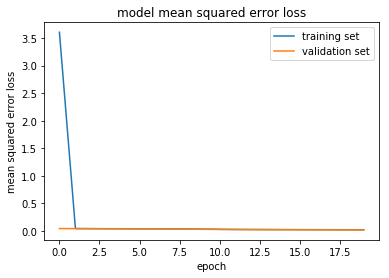

In [7]:
'''
### 可视化loss，分析并优化
# print the keys contained in the history object
print(history_object.history.keys())
# plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
'''

#### training 2：模型不够复杂，参考NVIDIA的End to End Learning for Self-driving Cars重新构建模型

In [6]:
train_generator = generator(train_samples, batch_size=128)
val_generator = generator(val_samples, batch_size=128)

model = Sequential()

## Crop output:90x320x3
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))

## Normalization
model.add(Lambda(lambda x: x/255 - 0.5))

## Conv1 output:43x158x24
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))
#model.add(MaxPooling2D((2, 2)))  

## Conv2 output:20x76x36
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))
#model.add(MaxPooling2D((2, 2)))

## Conv3 output:8x36x48
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))
#model.add(MaxPooling2D((2, 2))) 

## Conv4 output:3x17x64
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D((2, 2))) 

## Conv5 output:1x15x64
model.add(Convolution2D(64, 3, 3, activation='relu'))

## Flatten
model.add(Flatten())

## FC1
model.add(Dense(100))
#model.add(Dropout(0.5))

## FC2
model.add(Dense(50))

## FC3
model.add(Dense(10))

## Output
model.add(Dense(1))

Adam(lr=0.0001)
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples)*2*3,
                                     validation_data=val_generator,
                                     nb_val_samples=len(val_samples), nb_epoch=5)
model.save('model2.h5')

Epoch 1/5
36162/36162 [==============================] - 221s - loss: 0.0288 - val_loss: 0.0199
Epoch 2/5
36162/36162 [==============================] - 202s - loss: 0.0177 - val_loss: 0.0133
Epoch 3/5
36162/36162 [==============================] - 202s - loss: 0.0161 - val_loss: 0.0167
Epoch 4/5
36162/36162 [==============================] - 202s - loss: 0.0152 - val_loss: 0.0162
Epoch 5/5
36162/36162 [==============================] - 202s - loss: 0.0143 - val_loss: 0.0164


dict_keys(['val_loss', 'loss'])


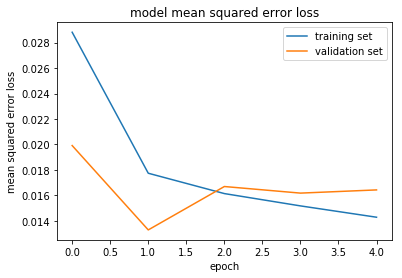

In [7]:
### 可视化loss，分析并优化
# print the keys contained in the history object
print(history_object.history.keys())
# plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')